In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

df = pd.read_excel("NOPD_-_Data_dictionary_for_Calls_For_Service_Open_Data.xlsx",usecols=(1,2))
df2016 = pd.read_csv("Calls_for_Service_2016.csv",low_memory=False)
df2017 = pd.read_csv("Calls_for_Service_2017.csv",low_memory=False)
df2018 = pd.read_csv("Calls_for_Service_2018.csv",low_memory=False)
df2019 = pd.read_csv("Calls_for_Service_2019.csv",low_memory=False)
df2020 = pd.read_csv("Call_for_Service_2020.csv",low_memory=False)

df2016 = df2016.rename(columns={"Type_":"Type"})
df2017 = df2017.rename(columns={"Type_":"Type"})
df2018 = df2018.rename(columns={"Type_":"Type"})
df2019 = df2019.rename(columns={"TimeArrival":"TimeArrive"})

In [10]:
df2020_type_distn = df2020['Type'].value_counts(normalize=True)
max_ndx = df2020_type_distn.argmax()
type_2020, val_2020 = df2020_type_distn.index[max_ndx],df2020_type_distn[max_ndx]

df2020_type_distn = df2020['Type'].value_counts(normalize=False)
df2016_type_distn = df2016['Type'].value_counts(normalize=False)

In [11]:
type_2020,val_2020

('22A', 0.23926753093150255)

In [15]:
k,v = None,0
for i in df2016_type_distn.keys():
    if i in df2020_type_distn.keys():
        p = (df2016_type_distn[i] - df2020_type_distn[i])/ df2016_type_distn[i]
        if p > 0:
            if p > v:
               v = p
               k = i
    
        #print("DOne with checking",i) #iteration 
    #else: print("key",i,"not found in 2020 data")  #sanity check
    #print(k,v)

In [16]:
k,v

('17R', 0.9835549610512235)

In [17]:
dfs_list = [ df2016, df2017, df2018, df2019, df2020 ]

df_all = pd.concat(dfs_list,ignore_index=True)
df_all_dropped = df_all.drop_duplicates(subset='NOPD_Item',keep='last')

In [18]:
total_duplicates = len(df_all) - len(df_all_dropped)

In [19]:
total_duplicates

5724

In [20]:
TA = pd.to_datetime(df_all_dropped['TimeArrive'])  #Arrival Time Series
TD = pd.to_datetime(df_all_dropped['TimeDispatch']) #Departure Time Series
total_time = (TA - TD).dt.total_seconds() #Total time in seconds
total_time = total_time[total_time>0] #filtering non-negative values or zero
medianDispatchTime = total_time.median()

In [21]:
medianDispatchTime

314.0

In [22]:
districts = df_all_dropped['PoliceDistrict'].unique()
districtDispatchTime = {}
for i in districts:
    temp_data = df_all_dropped[df_all_dropped['PoliceDistrict'] == i]
    TD_district = pd.to_datetime(temp_data['TimeDispatch'])
    TA_district = pd.to_datetime(temp_data['TimeArrive'])
    TT_district = (TA_district - TD_district).dt.total_seconds()
    TT_district = TT_district[TT_district>0]
    mean_dis, min_dis,max_dis = TT_district.mean(),TT_district.min(),TT_district.max()
    districtDispatchTime[i] = mean_dis, mean_dis - min_dis, max_dis - mean_dis

In [23]:
districtDispatchTime

{8: (438.03171690305135, 437.03171690305135, 210264.96828309694),
 0: (680.7837582625118, 679.7837582625118, 66793.2162417375),
 7: (742.2272767021705, 741.2272767021705, 215794.77272329782),
 6: (425.8739334064649, 424.8739334064649, 54883.12606659353),
 4: (518.3221568447182, 517.3221568447182, 228153.67784315528),
 1: (418.6906231527432, 417.6906231527432, 105603.30937684726),
 5: (506.7537709329933, 505.7537709329933, 152056.246229067),
 2: (491.31817854715547, 490.31817854715547, 59807.681821452854),
 3: (507.94370428495364, 506.94370428495364, 127928.05629571505)}

In [24]:
dDT_mean, dDT_shortdiff, dDT_longdiff = np.array(list(districtDispatchTime.values())).mean(axis=0) #mean values from different districts
val = dDT_longdiff - dDT_shortdiff

In [25]:
val

135173.7899735474

In [26]:
#Months wise data and averaging over same months in different years    
MMYY = {i:np.empty(0) for i in range(2016,2021)}

for i in MMYY.keys():
    temp_values = []
    for j in range(1,13):
        TD_temp = TD[(TD.dt.year == i) & (TD.dt.month == j)]
        TA_temp = TA[TD_temp.index]
        TT_temp = (TA_temp - TD_temp).dt.total_seconds()
        TT_temp = TT_temp[TT_temp>0]
        temp_values.append(TT_temp.mean())
    MMYY[i] = np.array(temp_values)

In [27]:
def linear_fit(x,m,c):
    return m*x + c
    

In [28]:
y = np.mean(np.array(list(MMYY.values())),axis=0)
yerr = np.std(np.array(list(MMYY.values())),axis=0)
x = np.linspace(1,12,12)/12
popt, pcov = curve_fit(linear_fit,x,y)
yfit = linear_fit(x,*popt)

In [30]:
popt

array([ 45.48138099, 488.74799513])

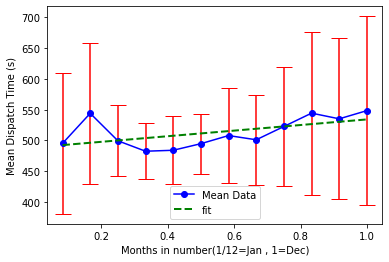

In [31]:
plt.errorbar(x,y,yerr,fmt=' ',c='r',capsize=8)
plt.xlabel("Months in number(1/12=Jan , 1=Dec)")
plt.ylabel("Mean Dispatch Time (s)")
plt.plot(x,y,'-o',c='b',label='Mean Data')
plt.plot(x,yfit,'g--',linewidth=2,label='fit')
plt.legend()
plt.show()

In [33]:
df_all_dropped_location = df_all_dropped.dropna(axis=0,subset=['Location'])
df_all_dropped_location1 = df_all_dropped_location[df_all_dropped_location['Location'] == '(0.0, 0.0)']
df_all_dropped_location1 = df_all_dropped_location1[df_all_dropped_location1['PoliceDistrict'] != 0]

event_count = {}
total_events = {}
for i in districts:
    temp_data = df_all_dropped_location1[df_all_dropped_location1['PoliceDistrict'] == i]
    total_events[i] = len(temp_data)
    temp_data = temp_data['Type'].value_counts()[temp_data['Type'].value_counts() > 100 ]
    event_count[i] = temp_data
total_events['all'] = sum(list(total_events.values()))
event_count['all'] = df_all_dropped_location1['Type'].value_counts()[df_all_dropped_location1['Type'].value_counts()>100]

ratio_dict = {}
for i in range(1,9):
    for j in event_count[i].keys():
        local_prob = event_count[i][j]/total_events[i]
        global_prob = event_count['all'][j]/total_events['all']
        l_by_g = local_prob/global_prob
        ratio_dict[(i,j)] = l_by_g
    
sorted_ratio = {k: v for k, v in sorted(ratio_dict.items(), key=lambda item: item[1])}
district_max = {}
for i in range(1,9):
    temp = 0
    max_key = None
    for k,v in sorted_ratio.items():
        if k[0] == i:
            if v > temp:
                temp = v
                max_key = k
    district_max[max_key] = temp
    
largest_ratio = {}
for k,v in district_max.items():
    cond_prob = (event_count['all'][k[1]] - event_count[k[0]][k[1]])/ (total_events['all'] - event_count[k[0]][k[1]])  #P(global|district)
    uncond_prob = event_count['all'][k[1]] / total_events['all']
    prob_rat = cond_prob / uncond_prob
    largest_ratio[k] = prob_rat


In [34]:
largest_ratio

{(1, '24K'): 0.07149505567030437,
 (2, '43B'): 0.8714633417663994,
 (3, '17J'): 0.46541681552745445,
 (4, '21J'): 0.8831580349831131,
 (5, '21J'): 0.8674444381454429,
 (6, '29ST'): 0.8573905569508524,
 (7, '21J'): 0.7348275970121456,
 (8, '24'): 0.7924314764062894}

In [38]:
df_all_dropped_location1[df_all_dropped_location1['Type'] == '24'].head(1)

,NOPD_Item,Type,TypeText,Priority,InitialType,InitialTypeText,InitialPriority,MapX,MapY,TimeCreate,...,TimeArrive,TimeClosed,Disposition,DispositionText,SelfInitiated,Beat,BLOCK_ADDRESS,Zip,PoliceDistrict,Location
0,D0808216,24,MEDICAL,2B,21,COMPLAINT OTHER,2A,37369000,3513814,04/07/2016 09:24:16 PM,...,04/07/2016 09:37:10 PM,04/07/2016 09:47:44 PM,NAT,Necessary Action Taken,N,8F02,Dauphine St & Pauger St,70116,8,"(0.0, 0.0)"


In [44]:
df_all_dropped_location = df_all_dropped.dropna(axis=0,subset=['Location'])

print("{0:8s}{1:>30s}".format("District","Area(sq. km)"))
for i in sorted(districts):
        district_loc = df_all_dropped_location[df_all_dropped['PoliceDistrict'] == i]
        arr = tuple(district_loc['Location'].replace(",","",regex=True).replace("POINT ","",regex=True).str.replace(")","",).str.replace("(",""))
        lat = []
        lon = []
        conv = 111 # in kilometers (1degree = 111km)
        ct = 0
        for v in arr[:]:
            temp = v.lstrip().split()
            temp = [float(temp[0]),float(temp[1])]
            try:
                if abs((temp[0])) < 0.00001 or abs((temp[1])) < 0.00001:
                    pass
                else:
                    if temp[0] > 0:
                       lat.append(temp[0])
                    else: lon.append(temp[0])
                    if temp[1] > 0:
                        lat.append(temp[1])
                    else: lon.append(temp[1])
                    
            except:
                print('Warning: Recheck if there is ERROR in Data')
            ct += 1
        lat = np.array(lat)
        lon = np.array(lon)
        lat = lat[abs(lat) < 32]
        lon = lon[abs(lon) > 85]
        std_lat = np.std(np.array(lat))
        std_lon = np.std(np.array(lon))
        #print(std_lat,std_lon)
        Area_of_ellipse = np.pi * std_lat * std_lon * conv**2
        print("{0:5d}{1:30.5f}".format(int(i),Area_of_ellipse))
        

District                  Area(sq. km)
    0                     384.44561
    1                       2.97495
    2                       5.71076
    3                      16.76961
    4                      10.20836
    5                       5.27350
    6                       3.04553
    7                      28.49802
    8                       0.96722


In [43]:
#Ignoring the District 0; the largest district is District 7